<a href="https://colab.research.google.com/github/sgr1118/NLP_Visualizer_Basic/blob/main/_8_%EC%8B%9C%ED%80%80%EC%8A%A4_%ED%88%AC_%EC%8B%9C%ED%80%80%EC%8A%A4%EC%99%80_%EC%96%B4%ED%85%90%EC%85%98_%EB%A9%94%EC%BB%A4%EB%8B%88%EC%A6%98_(Sequence_to_Sequence_with_Attention_Mechanism)_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 시퀀스 투 시퀀스와 어텐션 메커니즘 <br />(Sequence to Sequence with Attention Mechanism)

- 참고: https://github.com/spro/practical-pytorch
- 참고: https://tutorials.pytorch.kr/intermediate/seq2seq_translation_tutorial.html




* 관련 문헌
  - Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation <https://arxiv.org/abs/1406.1078>
  - Sequence to Sequence Learning with Neural Networks <https://arxiv.org/abs/1409.3215>
  - Neural Machine Translation by Jointly Learning to Align and Translate <https://arxiv.org/abs/1409.0473>
  - A Neural Conversational Model <https://arxiv.org/abs/1506.05869>

- 두 개의 순환 신경망(RNN)이 한 시퀀스를 다른 시퀀스로 변환하기 위해 함께 작동하는 시퀀스 투 시퀀스 네트워크
- 인코더(Encoder) 네트워크는 입력 시퀀스를 단일 벡터로 압축하고 디코더(Decoder) 네트워크는 해당 벡터를 새로운 시퀀스로 전개
- 이 모델을 개선하기 위해 디코더가 입력 시퀀스의 특정 범위에 초점을 맞추는 것을 배울 수 있는 어텐션 메커니즘(Attention Mechanism)을 사용

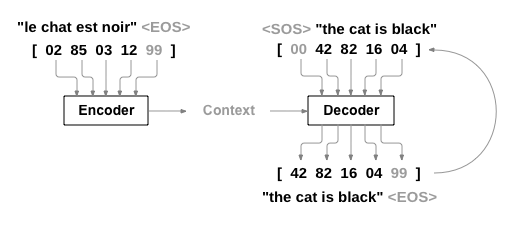

## 영어-프랑스어 기계번역

### 데이터 로드 및 전처리

- 수천 개의 영어-프랑스어 번역 쌍
- 다국어 문장 및 번역 서비스 (https://tatoeba.org/en/)
- 언어 쌍을 개별 텍스트 파일로 분할 (https://www.manythings.org/anki/)
- 영어-프랑스어 쌍으로 구성된 `eng-fra.txt` 파일 다운로드


    ...
    I know.	Je sais.
    I left.	Je suis parti.
    I left.	Je suis partie.
    I lost.	J'ai perdu.
    I'm 19.	J'ai 19 ans.
    I'm OK.	Je vais bien.
    ...

`eng-fra.txt` 파일 다운로드 (http://suanlab.com/datasets/eng-fra.txt)

In [ ]:
!wget http://suanlab.com/datasets/eng-fra.txt

--2023-02-11 06:15:19--  http://suanlab.com/datasets/eng-fra.txt
Resolving suanlab.com (suanlab.com)... 52.219.148.56
Connecting to suanlab.com (suanlab.com)|52.219.148.56|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9541158 (9.1M) [text/plain]
Saving to: ‘eng-fra.txt.1’

eng-fra.txt.1       100%[===================>]   9.10M  4.80MB/s    in 1.9s    

2023-02-11 06:15:22 (4.80 MB/s) - ‘eng-fra.txt.1’ saved [9541158/9541158]



- 언어의 각 단어를 One-Hot 벡터 또는 단어의 색인에서 하나만 1이고 나머지는 0인 거대한 벡터로 표현
- 번역에는 아주 많은 단어들이 포함되어 있기 때문에 인코딩 벡터는 너무 큼
- 그러나 약간의 트릭을 사용해 언어 당 수천개의 단어만
사용하도록 데이터 전처리

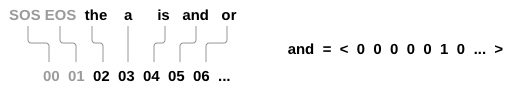

- 네트워크의 입력 및 목표로 사용하려면 단어 당 고유 번호가
필요
- 이 모든 것을 추적하기 위해 단어→색인(`word2index`)과 색인→단어(`index2word`) 사전 사용
- 나중에 희귀 단어를 대체하는데 사용할 각 단어의 빈도 `word2count`를 가진 ``Lang`` 이라는 헬퍼 클래스를 사용




In [ ]:
SOS_token = 0
EOS_token = 1

class Lang: 
    def __init__(self, name): # 초기화 대상 name
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: 'SOS', 1 : 'EOS'}
        self.n_words = 2 # SOS와 EOS 포함

    def add_sentence(self, sentence): # 실제 문장이 추가되는 부분
        for word in sentence.split(' '): # 문장을 ' '단위로 구분한다.
            self.add_word(word) # word로 출력

    def add_word(self, word):
        if word not in self.word2index: # word2index가 초기에는 비어있기에 포함되지않는 word를 저장
            self.word2index[word] = self.n_words
            self.word2count[word] = 1 # 처음에 한번도 포함되지 않은 word가 들어오니 word2count는 1로 지정한다.
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1 # word가 word2index에 포함된다면 word2count에 빈도만 +1을 한다.


- 로드한 텍스트 파일은 모두 유니코드(Unicode)로 되어있어 ASCII로 변환
- 모든 문자를 소문자로 만들고, 대부분의 구두점을 제거




In [ ]:
# 유니 코드 문자열을 일반 ASCII로 변환

def unicode2ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# 소문자, 다듬기, 문자가 아닌 것을 제거

def normalize_string(s):
    s = unicode2ascii(s.lower().strip())
    s = re.sub(r'([.!?])', r'\1', s)
    s = re.sub(r'[^a-zA-Z.!?]', r' ', s)
    return s

- 파일을 읽어서 줄 단위로 분리
- 모든 줄을 쌍으로 분리하고 정규화 수행
- 파일은 모두 [영어 → 다른 언어]로 구성되어 있어서 [다른 언어 → 영어]로 번역하기 위해 쌍을 반전시키는 역방향 flag 추가

In [ ]:
def read_langs(lang1, lang2, reverse = False):
    # 파일을 읽고 줄로 분리
    lines = open('%s-%s.txt' % (lang1, lang2), encoding = 'utf-8').\
     read().strip().split('\n')

    # 모든 줄을 쌍으로 분리하고 정규화
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]

    # 쌍을 뒤집고, Lang 인스턴스 수행
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

- 예시 문장이 많지만, 빠르게 학습하기를 원하기 때문에 비교적 짧고 간단한 문장으로만 데이터 셋을 정리
- 최대 길이는 10 단어(종료 문장 부호 포함)이며 "I am" 또는
"He is" 등의 형태로 번역되는 문장으로 필터링 (이전에 `'`(apostrophes)는 대체 됨)




In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
            len(p[1].split(' ')) < MAX_LENGTH and \
            p[1].startswith(eng_prefixes)


def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)] # 긴 문장을 제거

데이터 준비를 위한 전체 과정

-  텍스트 파일을 읽고 줄로 분리하고, 줄을 쌍으로 분리
-  텍스트를 정규화 하고 길이와 내용으로 필터링
-  쌍을 이룬 문장들로 단어 리스트를 생성




In [ ]:
import re
import random
import unicodedata

def prepare_data(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1, lang2, reverse)
    print('Read sentence pairs: ', len(pairs)) # pairs 수 출력

    pairs = filter_pairs(pairs)
    print('Trimmed to sentence pairs: ', len(pairs))

    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])

    print(input_lang.name, 'counted words: ', input_lang.n_words)
    print(output_lang.name, 'counted words: ', output_lang.n_words)

    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data('eng', 'fra', True)
print(random.choice(pairs))

Read sentence pairs:  135842
Trimmed to sentence pairs:  11340
fra counted words:  5674
eng counted words:  3788
['ce ne sont pas des criminelles.', 'they re not criminals.']


### Seq2Seq 모델

- 시퀀스 투 시퀀스 네트워크, seq2seq 네트워크, 또는 인코더 디코더 네트워크는 인코더와 디코더라고 불리는 두 개의 분리된 RNN으로 구성된 모델
- 인코더는 입력 시퀀스를 한 번에 하나씩 읽고 각 단계에서 벡터를 출력
- 인코더의 최종 출력은 컨텍스트 벡터로 유지
- 디코더는 이 컨텍스트 벡터를 사용하여 한 번에 한 단계씩 출력 시퀀스를 생성

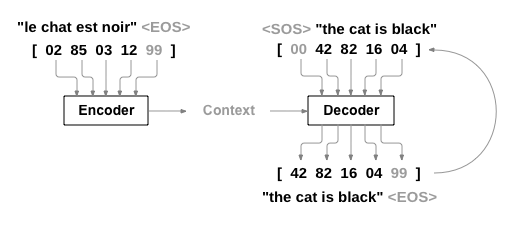

- 단일 RNN을 사용할 때 입력과 출력 사이에 일대일 관계가 존재
- 일반적으로 번역 시에 서로 다른 시퀀스 순서와 길이의 문제에 직면
  - "Je ne suis pas le chat noir" → "I am not the black cat
  - 많은 단어들은 "chat" → "cat"과 같이 꽤 직접적으로 번역
  - 문법이 다르면 단어들의 순서가 다름
  - 두 문장의 길이를 다르게 만드는 "ne...pass" → "not" 구조도 있음

- Seq2Seq 모델을 사용하여, 많은 입력을 하나의 벡터로 인코딩하고, 하나의 벡터에서 많은 출력으로 디코딩함으로써, 시퀀스 순서와 길이의 제약으로부터 자유로움
- 인코딩된 시퀀스는 N차원 공간의 단일 지점인 단일 벡터로 표현

#### 인코더(Encoder)

- seq2seq 네트워크의 인코더는 입력 문장에서 모든 단어에 대한 일부 값을 출력하는 RNN
- 모든 입력 단어에 대해 인코더는 벡터와 숨겨진 상태를 출력하고 다음 입력 단어에 숨겨진 상태를 사용


  $h_t = \text{EncoderRNN}(e(x_t), h_{t-1})$

  - 여기서 input sentence는 $X = \{x_1, x_2, ..., x_T\}$로 표현
  - 초기 hidden state, $h_0$는 0이 되거나 학습된 parameter로 초기화

- RNN은 LSTM (Long Short-Term Memory)나 GRU (Gated Recurrent Unit)와 같은 구조를 사용 가능


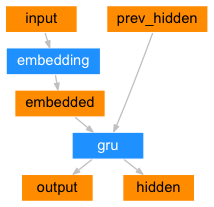

**문맥 벡터(context vector)**

- 최종 단어인 $x_T$, `<eos>`가 embedding layer를 통해 RNN에 전달되면, 마지막 hidden state인 $h_T$을 얻을 수 있으며, 이를 context vector라고 부름
- context vector는 전체 문장을 대표하며, $h_T = z$로 표현 가능

In [ ]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size): # hidden_size를 받아 계산
        super(EncoderRNN, self).__init__() 
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size) # 받은 크기만큼 embbding
        self.gru = nn.GRU(hidden_size, hidden_size) # hidden_size 만큼 GRU를 가져온다

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1) #
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### 디코더(Decorder)

- 디코더는 인코더 출력 벡터를 받아서 번역을 생성하기 위한 단어 시퀀스를 출력




- 가장 간단한 Seq2Seq 디코더는 인코더의 마지막 출력만을 이용
- 마지막 출력은 전체 시퀀스에서 문맥을 인코드하기 때문에 *문맥 벡터(context vector)* 로 불림
- 이 문맥 벡터는 디코더의 초기 은닉 상태로 사용
- 디코딩의 매 단계에서 디코더에게 입력 토큰과 은닉 상태가 주어짐
- 초기 입력 토큰은 문자열-시작 (start-of-string) ``<SOS>`` 토큰이고, 첫 은닉 상태는 문맥 벡터(인코더의 마지막 은닉 상태)

  $s_t = \text{DecoderRNN}(d(y_t), s_{t-1})$

  - context vector인 $z$를 output/target sentence로 디코딩해야함

  - 여기서 현재 단어를 embedding, $y$한 값이 $d(y_t)$이며, context vector $z = h_T$는 첫번째 hidden state인 $s_0$과도 같음

- decoder의 hidden state $s_t$를 `Linear layer`에 넣음으로써 prediction값을 얻을 수 있음

  $\hat{y}_t = f(s_t)$

- decoder의 단어는 각 time step당 하나씩 차례대로 생성
- decoder를 거치면서 많은 단어들이 생성이 되는데, `<eos>` token이 출력되면 decoding을 멈춤
- 예측값  $\hat{Y} = \{ \hat{y}_1, \hat{y}_2, ..., \hat{y}_T \}$을 실제 target sentece의 값 $Y = \{ y_1, y_2, ..., y_T \}$과 비교하여 정확도를 계산

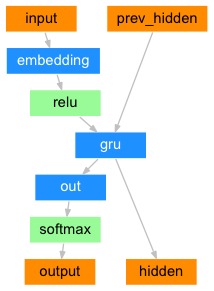

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device = device)

간단한 디코더를 이용한 모델의 결과를 학습하고 관찰하는 것을 권장하지만, 좀 더 좋은 성능 개선을 위한 Attention 메커니즘을 바로 도입




### 어텐션 메커니즘(Attention Mechanism)

- 고정 길이 벡터는 입력 시퀀스의 전체 "의미"를 인코딩하는 부담을 가짐
- 언어의 모든 차이와 함께 이것은 매우 어려운 문제
- 한 단어만 다른 20단어 길이로 거의 동일한 두 문장을 생각
- 인코더와 디코더 모두 공간의 약간 다른 점으로 그 변화를 나타낼 수 있을 만큼 미묘한 차이를 가져야 함

- 어텐션 메커니즘은 디코더에게 단일 벡터에 의존하지 않고 입력 부분에 "Attention" 할 수 있는 방법을 제공함으로써 이를 해결
- 모든 단계에서 디코더는 고려할 입력 문장의 다른 부분을 선택할 수 있음

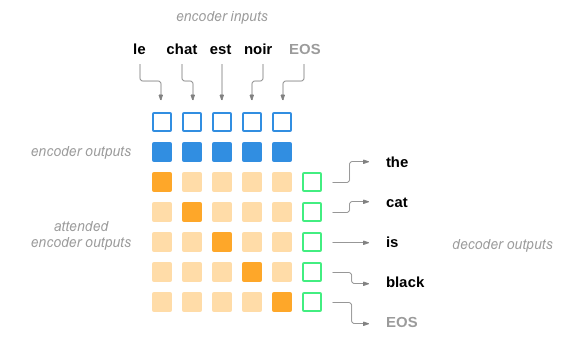

- 어텐션은 디코더에서 다른 피드포워드 레이어로 계산
- 이 계층은 현재 입력 및 숨김 상태를 사용하여 입력 시퀀스와 동일한 크기(실제로 고정된 최대 길이)의 새 벡터를 생성
- 이 벡터는 softmax를 통해 처리되어 어텐션 가중치를 생성하고, 이 가중치를 인코더의 출력에 곱하여 새로운 컨텍스트 벡터를 생성하고, 다음 출력을 예측하는 데 사용

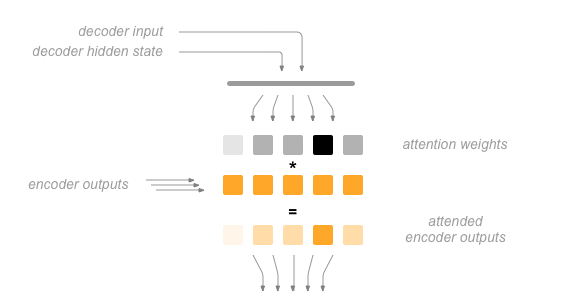

#### Attention 디코더

- 문맥 벡터만 인코더와 디코더 사이로 전달 된다면, 단일 벡터가 전체 문장을 인코딩 해야하는 부담을 가지게 됨
- Attention은 디코더 네트워크가 자기 출력의 모든 단계에서 인코더 출력의 다른 부분에 "집중" 할 수 있게 함
  - 첫째 *Attention 가중치* 의 세트를 계산
  - 가중치 조합을 만들기 위해서 인코더 출력 벡터와
곱함
  - 그 결과(코드에서 `attn_applied`)는 입력 시퀀스의
특정 부분에 관한 정보를 포함해야하고 따라서 디코더가 알맞은 출력
단어를 선택하는 것을 도와줌

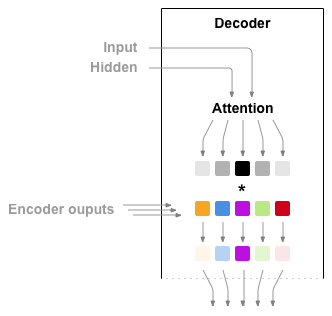

- 어텐션 가중치 계산은 디코더의 입력 및 은닉 상태를 입력으로
사용하는 다른 feed-forwad 계층인 `attn` 으로 수행
- 학습 데이터에는 모든 크기의 문장이 있기 때문에 이 계층을 실제로 만들고 학습시키려면 적용 할 수 있는 최대 문장 길이 (인코더 출력을 위한 입력 길이)를 선택해야 함
- 최대 길이의 문장은 모든 Attention 가중치를 사용하지만
더 짧은 문장은 처음 몇 개만 사용

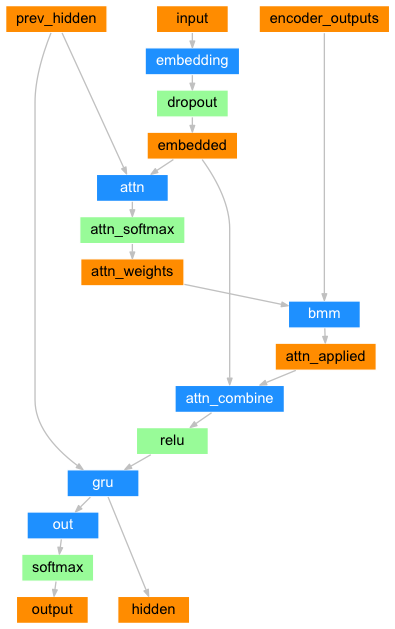

In [ ]:
import torch.nn.functional as F

class AttentionRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p = 0.1, max_length = MAX_LENGTH):
        super(AttentionRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embeding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embeding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim = 1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        # 가중치 값 차원 낮추기
        # bmm : 배치에 대한 행렬 곱

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim = 1)
        return output, hidden, attn_weights

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device = device)

### 학습 데이터 준비

- 학습을 위해서 각 쌍마다 입력 Tensor(입력 문장의 단어 주소)와
목표 Tensor(목표 문장의 단어 주소)가 필요
- 이 벡터들을 생성하는 동안 두 시퀀스에 EOS 토큰을 추가

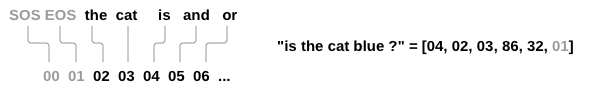

In [ ]:
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensor_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)
    
def tensors_from_pair(pair):
    input_tensor = tensor_from_sentence(input_lang, pair[0])
    target_tensor = tensor_from_sentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### 모델 학습

- 학습을 위해서 인코더에 입력 문장을 넣고 모든 출력과 최신 은닉 상태를 추적
- 그런 다음 디코더에 첫 번째 입력으로 ``<SOS>`` 토큰과
인코더의 마지막 은닉 상태가 첫번쩨 은닉 상태로 제공
- "Teacher forcing"은 다음 입력으로 디코더의 예측을 사용하는 대신 실제 목표 출력을 다음 입력으로 사용하는 컨셉
- "Teacher forcing"을 사용하면 수렴이 빨리되지만 `학습된 네트워크가 잘못 사용될 때 불안정성을 보임
- Teacher-forced 네트워크의 출력이 일관된 문법으로 읽지만 정확한 번역과는 거리가 멀다는 것을 볼 수 있음
- 직관적으로 출력 문법을 표현하는 법을 배우고 교사가 처음 몇 단어를 말하면 의미를 "선택" 할 수 있지만, 번역에서 처음으로 문장을 만드는 법은 잘 배우지 못함
- PyTorch의 autograd가 제공하는 편리함 덕분에 간단한 If 문으로
Teacher Forcing을 사용할지 아니면 사용하지 않을지를 선택할 수 있음 (`teacher_forcing_ratio`를 확인)




In [ ]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder,
          encoder_optimizer, deocder_optimizer, criterion, max_length = MAX_LENGTH):
    encoder_hidden = encoder.init_hidden()

    encoder_optimizer.zero_grad() # 초기화
    deocder_optimizer.zero_grad()

    input_length = input_tensor.size(0) # 아까 계산한 tensor size로 계산
    target_length = target_tensor.size(0)

    # encoder 결과는 amx_length 크기만큼 초기화
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device = device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device = device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing 포함 : 목표를 다음 입력으로 전달
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs) 
            loss += criterion(decoder_output, target_tensor[di]) # loss 계산
            decoder_input = target_tensor[di] # Teacher forcing

    else:
        # Teacher forcing 미포함 : 자신의 예측을 다음 입력으로 사용
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1) # 실제 디코더 input의 topk 중 1개를 선택
            decoder_input = topi.squeeze().detach() # 입력으로 사용한 부분을 히스토리에서 분리

            loss += criterion(decoder_output, target_tensor[di]) # loss 계산
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    deocder_optimizer.step()

    return loss.item() / target_length

현재 시간과 진행률%을 고려해 경과된 시간과 남은 예상
시간을 출력하는 함수




In [ ]:
import time
import math

def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

matplotlib로 학습 중에 저장된 손실 값 `plot_losses`의 배열을 사용하여 도식화




In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

전체 학습 과정
- 타이머 시작
- optimizers와 criterion 초기화
- 학습 쌍의 세트 생성
- 도식화를 위한 빈 손실 배열 시작

여러 번 `train`을 호출하며 진행률(예제의 %, 현재까지의 예상 시간)과 평균 손실을 출력




In [ ]:
import time
from torch import optim

def train_iters(encoder, decoder, n_iters, print_every = 1000, plot_every = 100, learning_rate = 0.01):
    start = time.time()

    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0  # plot_every 마다 초기화

    encoder_optimizer = optim.SGD(encoder.parameters(), lr = learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr = learning_rate)
    training_pairs = [tensors_from_pair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder,
                     encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('Iteration : {:}/{:}'.format(iter, n_iters),
                  '| Loss: {:.4f}'.format(print_loss_avg),
                  '| Elapsed Time: {:s}'.format(time_since(start, iter / n_iters)))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses

### 평가

- 평가는 대부분 학습과 동일하지만 목표가 없으므로 각 단계마다 디코더의 예측을 되돌려 전달
- 단어를 예측할 때마다 그 단어를 출력 문자열에 추가
- 만약 EOS 토큰을 예측하면 거기에서 멈춤
- 나중에 도식화를 위해서 디코더의 Attention 출력을 저장




In [ ]:
def evaluate(encoder, decoder, sentence, max_length = MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.init_hidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device = device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[EOS_token]], decice = device) # SOS
        decodet_hidden = encoder_hidden
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decodet_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di, + 1]

학습 세트에 있는 임의의 문장을 평가하고
입력, 목표 및 출력을 출력하여 주관적인 품질 판단을 내릴 수 있음




In [ ]:
def evaluate_randomly(encoder, decoder, n = 10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

### 학습과 평가

- 네트워크를 초기화하고 학습을 시작
- 입력 문장이 많이 필터링 되었음을 기억해야 함
- 이 작은 데이터 세트의 경우 256 크기의 은닉 노드(hidden node)와 단일 GRU 계층 같은 상대적으로 작은 네트워크를 사용할 수 있음

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttentionRNN(hidden_size, output_lang.n_words, dropout_p = 0.1).to(device)

plot_losses = train_iters(encoder1, attn_decoder1, 75000, print_every=5000)

Iteration : 5000/75000 | Loss: 3.0894 | Elapsed Time: 3m 18s (- 46m 18s)
Iteration : 10000/75000 | Loss: 2.5957 | Elapsed Time: 6m 42s (- 43m 33s)
Iteration : 15000/75000 | Loss: 2.2349 | Elapsed Time: 10m 6s (- 40m 24s)
Iteration : 20000/75000 | Loss: 2.0016 | Elapsed Time: 13m 29s (- 37m 5s)
Iteration : 25000/75000 | Loss: 1.8316 | Elapsed Time: 16m 51s (- 33m 43s)
Iteration : 30000/75000 | Loss: 1.6318 | Elapsed Time: 20m 13s (- 30m 20s)


KeyboardInterrupt: ignored

In [ ]:
evaluate_randomly(encoder1, attn_decoder1)

### Attention 시각화

- Attention 메커니즘의 유용한 속성은 하나는 해석 가능성이 높은 출력
- 입력 시퀀스의 특정 인코더 출력에 가중치를 부여하는 데 사용되므로 각 시간 단계에서 네트워크가 가장 집중되는 위치를 파악할 수 있음
- Attention 출력을 행렬로 표시하기 위해 `plt.matshow(attentions)` 를 간단하게 실행할 수 있음
- 열은 입력 단계와 행이 출력 단계




축과 라벨을 더하여 보기 좋게 출력


